<a href="https://colab.research.google.com/github/jespimentel/perfil_mpsp/blob/main/perfil_membros_mpsp_2023_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Idade e tempo de carreira dos membros do MPSP

Análise de dados extraídos de PDFs (listas de antiguidade), com extração de informações com PyMuPDF

In [1]:
!pip install pymupdf

In [2]:
import fitz
import re
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
arquivos = ['/content/1-Lista-I-Procurador.pdf','/content/2-Lista-II-Final.pdf', '/content/3-Lista-III-Intermediaria.pdf',
            '/content/4-Lista-IV-Inicial.pdf','/content/5-Lista-V-Substituto.pdf']

In [4]:
def extrai_texto(arquivo):
  """Extrai o texto do PDF"""
  texto = ''
  with fitz.open(arquivo) as pdf:
    for pagina in pdf:
      texto += pagina.get_text()
  return texto

texto = ''
for arquivo in arquivos:
  texto += extrai_texto(arquivo)

texto = texto.replace('\n', ',')

# Expressão regular com lookahead
# O lookahead é denotado por (?=...).
# A expressão encontra a substring que é seguida por outra substring (no caso, o mesmo padrão), sem incluir essa última sequência no resultado da busca.
# re.DOTALL garante que se possa trabalhar com várias linhas

membros = re.compile('([0-9]+,[0-9]+,[A-ZÀ-Ú].+?)(?=[0-9]+,[0-9]+,[A-ZÀ-Ú].+|$)', re.DOTALL)

# Gera a lista
lista_membros = membros.findall(texto)
print(f'Total de membros encontrados: {len(lista_membros)}')

Total de membros encontrados: 2009


In [5]:
# Limpeza dos dados
"""
L     I     S     T     A
Obs.: (1) refere-se
DATA DE

"""
padroes_para_remover = [r"L\s*I\s*S\s*T\s*A.*", r"Obs\..*", r"DATA DE.*"]

for i in range(len(lista_membros)):
    for padrao in padroes_para_remover:
        lista_membros[i] = re.sub(padrao, "", lista_membros[i])

In [6]:
for i in range(len(lista_membros)):
    lista_membros[i] = [elemento.strip() for elemento in lista_membros[i].split(',') if elemento.strip()] # Só inclui na lista se não for elemento vazio

In [7]:
# Expressão regular para encontrar datas no formato dd/mm/yyyy
regex = r"\b\d{2}/\d{2}/\d{4}\b"

# Percorrer a lista de listas e limpar os elementos
lista_limpa = []
for sublista in lista_membros:
    sublista_limpa = []
    for elemento in sublista:
      if isinstance(elemento, str):
        # Procurar por uma data no elemento atual
        match = re.search(regex, elemento)
        if match:
            # Substitui o elemento pela data encontrada
            sublista_limpa.append(match.group())
        else:
            # Mantém o elemento original se não encontrar uma data
            sublista_limpa.append(elemento)
    lista_limpa.append(sublista_limpa)

lista_membros = lista_limpa

In [8]:
lista_geral = []
for membro in lista_membros:
  elemento = []
  elemento.append(membro[0])
  elemento.append(membro[1])
  elemento.append(membro[2])
  elemento.append(membro[4])
  for item in membro[5:]:
    regex = r"^\d{2}/\d{2}/\d{4}$"
    if isinstance(item, str) and re.match(regex, item):
        elemento.append(item)

  lista_geral.append(elemento)

In [9]:
# nascimento, inicio_carreira, entrancia_anterior, situacao_atual
# Substitutos: 7 elementos na lista

lista_geral_1 = []
for membro in lista_geral:
  elemento = []
  elemento.append(membro[0])
  elemento.append(membro[1])
  elemento.append(membro[2])
  if len(membro) == 7:
    elemento.append(membro[-1]) # nascimento
    elemento.append(membro[-2]) # inicio_carreira
    elemento.append('') # entrancia_anterior
    elemento.append(membro[-3]) # situacao_atual
  else:
    elemento.append(membro[-1]) # nascimento
    elemento.append(membro[-3]) # inicio_carreira
    elemento.append(membro[-2]) # entrancia_anterior
    elemento.append(membro[-4]) # situacao_atual

  lista_geral_1.append(elemento)

In [ ]:
colunas = ['classificacao', 'matricula', 'nome', 'nascimento', 'inicio_carreira', 'entrancia_anterior', 'situacao_atual']
df = pd.DataFrame(lista_geral_1, columns=colunas)
df.sample(3)

In [ ]:
# Estratégia para incorporar ao dataframe o n. da lista a que se refere a sequência (de 'classificacao')
df['lista'] = df['classificacao'].astype(int).diff().lt(0).cumsum() + 1
df = df[['lista', 'classificacao', 'matricula', 'nome', 'nascimento', 'inicio_carreira', 'entrancia_anterior', 'situacao_atual']]
df.sample(3)

In [ ]:
df['nascimento'] = pd.to_datetime(df['nascimento'], format='%d/%m/%Y', errors='coerce')
df['inicio_carreira'] = pd.to_datetime(df['inicio_carreira'], format='%d/%m/%Y', errors='coerce')
df['entrancia_anterior'] = pd.to_datetime(df['entrancia_anterior'], format='%d/%m/%Y', errors='coerce')
df['situacao_atual'] = pd.to_datetime(df['situacao_atual'], format='%d/%m/%Y', errors='coerce')
df.sample(3)

In [13]:
df['inicio_carreira']

0      1977-09-13
1      1976-01-13
2      1978-12-01
3      1976-09-22
4      1977-09-13
          ...    
2004   2023-03-31
2005   2023-03-31
2006   2023-03-31
2007   2023-03-31
2008   2023-03-31
Name: inicio_carreira, Length: 2009, dtype: datetime64[ns]

In [ ]:
hoje = datetime.today()

df['idade_ingresso_mp'] = (df['inicio_carreira'] - df['nascimento']).dt.days/365.25
df['tempo_ent_anterior'] = ((df['situacao_atual'] - df['entrancia_anterior']).dt.days/365.25).fillna(0)
df['tempo_ate_situacao_atual'] = ((df['situacao_atual'] - df['inicio_carreira']).dt.days/365.25).fillna(0)
df['tempo_ent_atual'] = (hoje - df['situacao_atual']).dt.days/365.25
df['tempo_de_carreira'] = (hoje - df['inicio_carreira']).dt.days/365.25
df['idade_atual'] = (hoje - df['nascimento']).dt.days/365.25
df['ano_de_ingresso'] = df['inicio_carreira'].dt.year.fillna(0).astype(int)
df['ano_ent_anterior'] = df['entrancia_anterior'].dt.year.fillna(0).astype(int)
df['ano_situacao_atual'] = df['situacao_atual'].dt.year.fillna(0).astype(int)
df

In [15]:
hoje.strftime('%Y-%m-%d')

'2024-01-19'

In [16]:
df.to_csv(f"/content/antiguidade_{hoje.strftime('%Y-%m-%d')}.csv", decimal = ',')

1.0394163997214254
-2041.790598358485


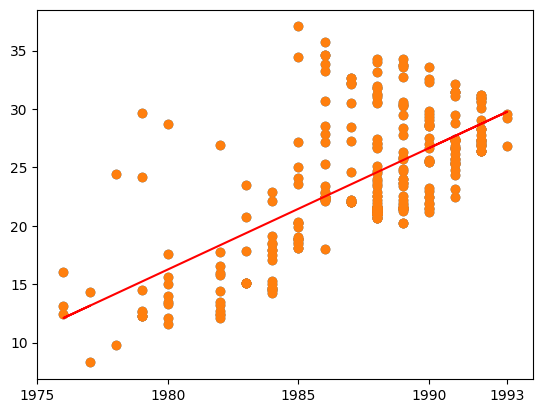

In [17]:
procuradores = df[df['lista']==1]
x = procuradores['ano_de_ingresso']
y = procuradores['tempo_ate_situacao_atual']

# Ajustando os limites do eixo X (opcional)
plt.xlim(1975, 1994)

# Definindo os marcadores do eixo X (opcional)
plt.xticks([1975, 1980, 1985, 1990, 1993]) #, ['um', 'dois', 'três', 'quatro', 'cinco'])


# Calculando a regressão linear
a, b = np.polyfit(x, y, 1)  # a é a inclinação, b é a interceptação
print(a)
print(b)

x_min = 1976  # Um pouco acima do limite inferior do eixo X
y_max = max(y) + 1  # Um pouco acima do valor máximo de y
#plt.text(x_min, y_max, f'y = {a:.2f}x + {b:.2f}', fontsize=12, color='blue')

# Criando o gráfico de dispersão
plt.scatter(x, y)

# Adicionando a reta de regressão
plt.plot(x, a * x + b, color='red')  # Reta de regressão


plt.scatter(x, y)
plt.show()

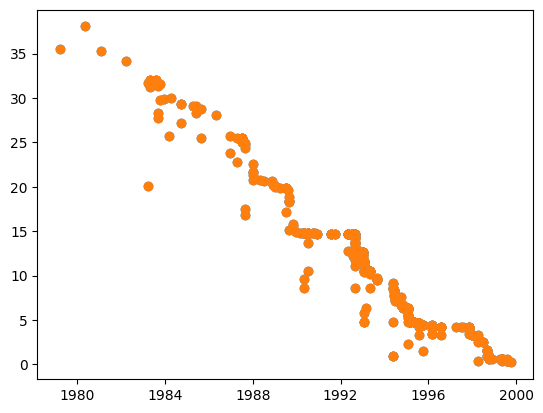

In [18]:
procuradores = df[df['lista']==1]
x = procuradores['entrancia_anterior']
y = procuradores['tempo_ent_atual']

# Criando o gráfico de dispersão
plt.scatter(x, y)

plt.scatter(x, y)
plt.show()

In [19]:
df.groupby(['inicio_carreira', 'lista'])['nome'].count().head(100)

inicio_carreira  lista
1976-01-13       1         1
1976-09-22       1         2
1977-09-13       1         2
                 2         1
1978-12-01       1         2
                          ..
2011-03-31       2        49
                 3        18
                 4         4
2012-04-09       2        43
                 3        20
Name: nome, Length: 100, dtype: int64

In [20]:
df.groupby(['lista'])['matricula'].count()

lista
1     299
2    1116
3     258
4     187
5     149
Name: matricula, dtype: int64

In [21]:
df.groupby(['lista'])[['tempo_de_carreira', 'idade_atual']].mean()

,tempo_de_carreira,idade_atual
lista,,
1,36.245033,62.852026
2,23.674863,51.075828
3,16.763775,45.757414
4,9.295194,39.451786
5,1.208274,33.370598


In [22]:
df.groupby(['lista'])[['tempo_de_carreira', 'idade_atual']].median()

,tempo_de_carreira,idade_atual
lista,,
1,35.630390,62.261465
2,24.596851,51.442847
3,16.462697,44.917180
4,7.991786,38.696783
5,0.804928,32.725530


In [23]:
df.groupby(['lista'])[['tempo_de_carreira', 'idade_atual']].std()

,tempo_de_carreira,idade_atual
lista,,
1,3.676306,4.825273
2,8.493326,7.477948
3,7.247134,6.631558
4,6.476941,6.078181
5,0.860277,3.776430


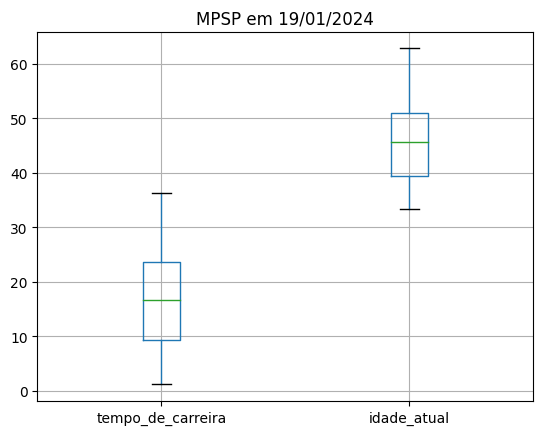

In [24]:
df.groupby(['lista'])[['tempo_de_carreira', 'idade_atual']].mean().boxplot()
plt.title(f"MPSP em {hoje.strftime('%d/%m/%Y')}")
plt.savefig("MPSP_idade_e_tempo_de_carreira.jpg")
plt.show()

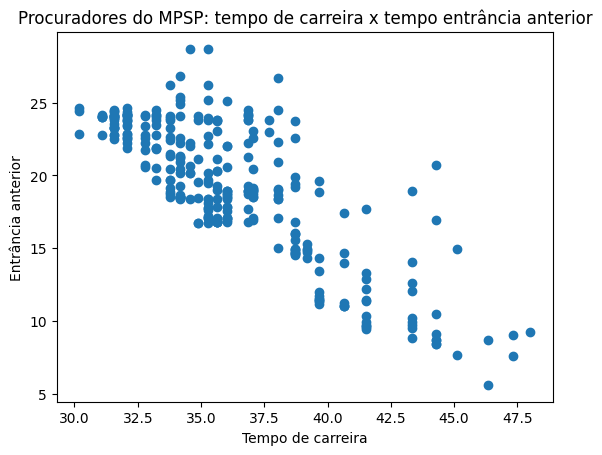

In [25]:
procuradores = df[df['lista']==1]
x = procuradores['tempo_de_carreira']
y = procuradores['tempo_ent_anterior']
plt.title('Procuradores do MPSP: tempo de carreira x tempo entrância anterior')
plt.xlabel('Tempo de carreira')
plt.ylabel('Entrância anterior')
plt.scatter(x,y)
plt.show()

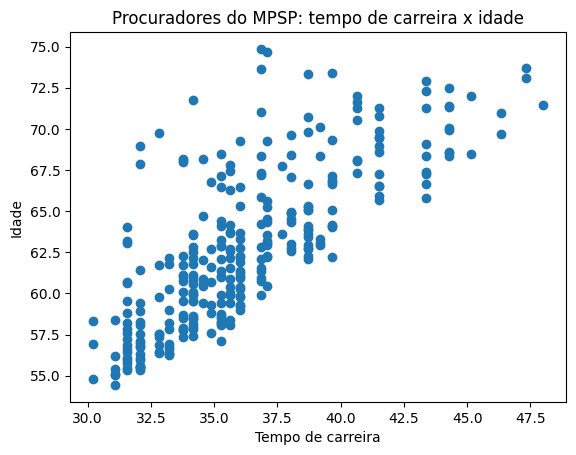

In [26]:
procuradores = df[df['lista']==1]
x = procuradores['tempo_de_carreira']
y = procuradores['idade_atual']
plt.title('Procuradores do MPSP: tempo de carreira x idade')
plt.xlabel('Tempo de carreira')
plt.ylabel('Idade')
plt.scatter(x,y)
plt.show()

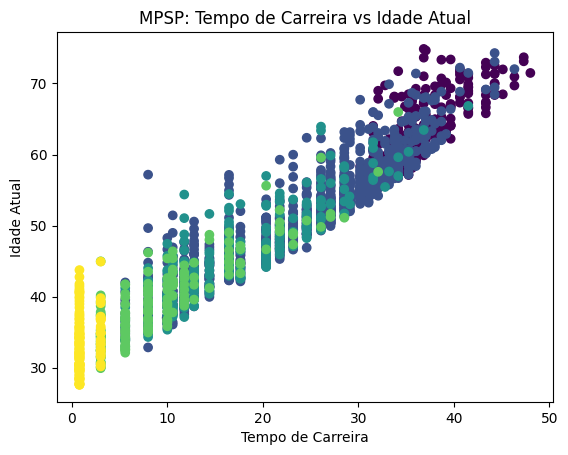

In [27]:
import matplotlib.pyplot as plt

# Dados do DataFrame
x = df['tempo_de_carreira']
y = df['idade_atual']
colors = df['lista']  # Usa a coluna 'lista' para definir as cores

plt.title('MPSP: Tempo de Carreira vs Idade Atual')
plt.xlabel('Tempo de Carreira')
plt.ylabel('Idade Atual')
plt.scatter(x, y, c=colors, cmap='viridis')  # 'cmap' define o mapa de cores
plt.savefig('MPSP_idade_e_tempo_de_carreira_1.jpg')
plt.show()


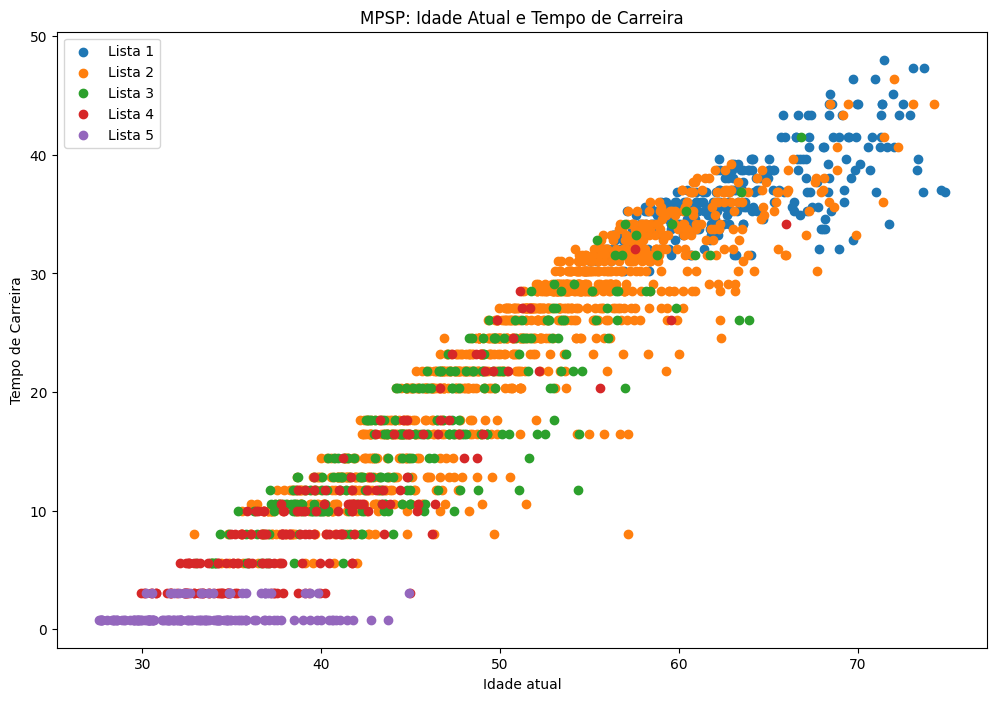

In [28]:
import matplotlib.pyplot as plt
# Preparando os dados
y = df['tempo_de_carreira']
x = df['idade_atual']
categorias = df['lista'].unique()  # Obtém as categorias únicas

plt.figure(figsize=(12, 8))  # Ajusta o tamanho do gráfico
plt.title('MPSP: Idade Atual e Tempo de Carreira')
plt.xlabel('Idade atual')
plt.ylabel('Tempo de Carreira')

# Criando um scatter plot para cada categoria
for categoria in categorias:
    indices = df['lista'] == categoria
    plt.scatter(x[indices], y[indices], label=f'Lista {categoria}')

# Mostrando a legenda
plt.legend()
plt.savefig('MPSP_idade_e_tempo_de_carreira_1.jpg')
plt.show()


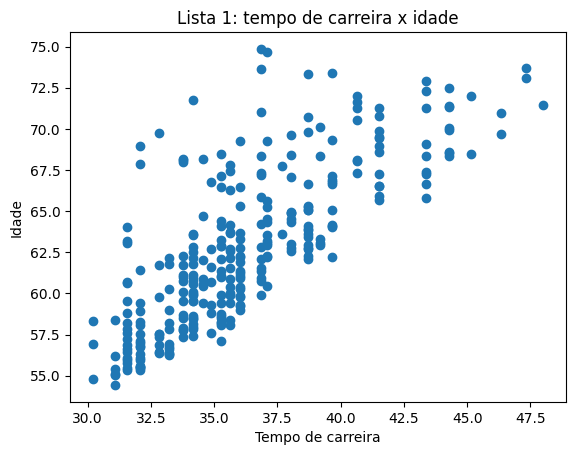

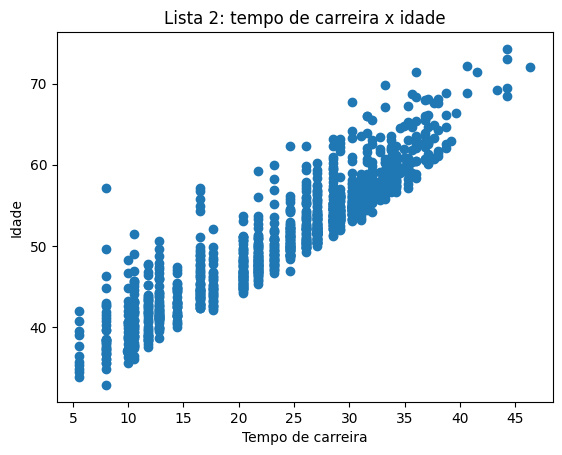

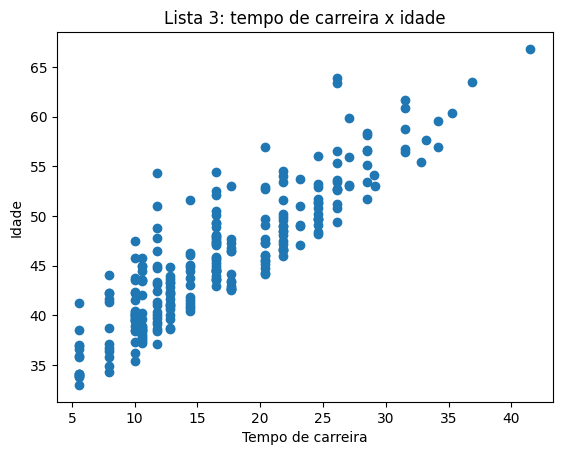

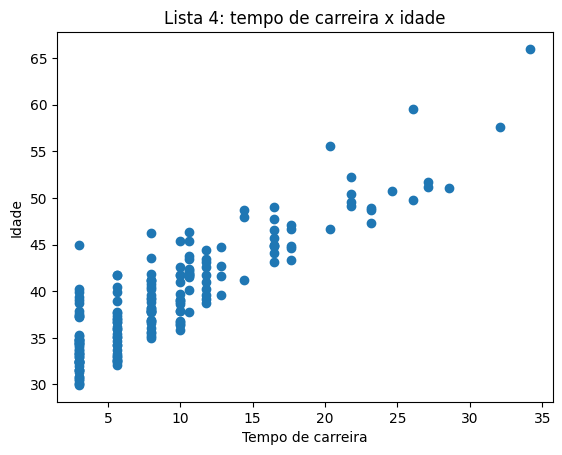

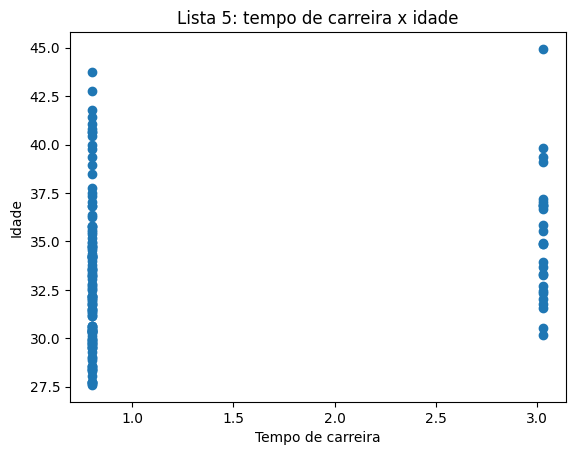

In [29]:
for n in range(1, 6):
  lista = df[df['lista']==n]
  x = lista['tempo_de_carreira']
  y = lista['idade_atual']
  plt.title(f'Lista {n}: tempo de carreira x idade')
  plt.xlabel('Tempo de carreira')
  plt.ylabel('Idade')
  plt.scatter(x, y)
  plt.savefig(f'lista_{n}_tempo_de_carreira_e_idade.jpg')
  plt.show()